# Mn-Salinity relationship


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
import cmocean
import pandas as pd 
import glob
import warnings
warnings.filterwarnings('ignore')
import pickle
import datetime
from datetime import date
import matplotlib
import xarray as xr

%matplotlib inline

###### Parameters:

In [2]:
imin, imax = 1480, 2180
jmin, jmax = 160, 800
isize = imax - imin
jsize = jmax - jmin

year  = 2015
month = 8
model_IC             = f'/ocean/brogalla/GEOTRACES/data/Mn_ini_20190802.nc'
marco_kox            = f'/data/brogalla/run_storage/Mn-tuning-202107/ANHA12_spin-up1_euphotic/'
results_folder_nospm = f'/data/brogalla/run_storage/Mn-tuning-202107/ANHA12_ref-{year}_20210722-nospm/'
results_folder_spm   = f'/data/brogalla/run_storage/Mn-tuning-202107/ANHA12_ref-{year}_20210722-spm/'
folder_salinity      = f'/data/brogalla/ANHA12/salinity_ave/'
folder_ref_2009      = f'/data/brogalla/run_storage/Mn-tuning-202107/ANHA12_ref-2009_euphotic/'
folder_ref_2015      = '/data/brogalla/run_storage/Mn-tuning-202107/ANHA12_ref-2015_euphotic/'

# colours:
obs_CB     = '#b23333'
obs_CAA    = '#d89999'
mod_CB     = '#006f99'
mod_CAA    = '#99c5d6'
land_color = "#8b7765"

In [3]:
# GEOTRACES stations indices:
stn_i = np.array([104-1, 100, 91, 175, 175, 233, 214, 352, 242, 458, 508, 547, 629])
stn_j = np.array([370, 365, 353, 311, 326, 313, 281, 281, 364, 332, 384, 457, 471])
stn_n = np.array(['CAA1','CAA2','CAA3','CAA4','CAA5','CAA6','CAA7',
                  'CAA8','CAA9', 'CB1','CB2','CB3','CB4'])

# IPY station indices: ### need to find
IPY_stn_i = np.array([658, 613, 574, 566, 613, 616])
IPY_stn_j = np.array([332, 342, 381, 408, 376, 289])

###### Load files:

In [4]:
mesh       = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
mesh_lon   = np.array(mesh.variables['nav_lon'])
mesh_lat   = np.array(mesh.variables['nav_lat'])
mesh_bathy = np.array(mesh.variables['hdept'][0])
tmask      = np.array(mesh.variables['tmask'][0,:,:,:])
Z_masked   = np.ma.masked_where((tmask > 0.1), tmask) 

Model results

In [5]:
c_spm   = nc.Dataset(f'{results_folder_spm}ANHA12_EXH006_{year}_monthly.nc', 'r')
c_nospm = nc.Dataset(f'{results_folder_nospm}ANHA12_EXH006_{year}_monthly.nc', 'r')

lat_model      = np.array(c_spm.variables['nav_lat'])
lon_model      = np.array(c_spm.variables['nav_lon'])
depths_model   = np.array(c_spm.variables['deptht'])
mn_model_spm   = np.array(c_spm.variables['dissolmn'])
mn_model_nospm = np.array(c_nospm.variables['dissolmn'])

In [6]:
fIC    = nc.Dataset(model_IC, 'r')
dMn_IC = np.array(fIC.variables['dMn'])[0,:,imin:imax,jmin:jmax]
oMn_IC = np.array(fIC.variables['oMn'])[0,:,imin:imax,jmin:jmax]

sal    = nc.Dataset(f'{folder_salinity}/ANHA12-EXH006_gridT_y2002m08.nc', 'r')
sal_IC = np.array(sal.variables['vosaline'])[0,:,imin:imax,jmin:jmax]

In [7]:
kox = nc.Dataset(f'{marco_kox}/ANHA12_EXH006_2002_monthly.nc', 'r')
dMn_kox = np.array(kox.variables['dissolmn'])[8,0,:,:,:]

Observations

In [8]:
# Concentration of dMn in 2015.
Manuel = pd.read_csv('/ocean/brogalla/GEOTRACES/data/DMn_nmolL-1_BR-edited.csv')
Manuel_station_names = Manuel['Station'].astype('string')
Manuel_depths        = Manuel['Depth'].astype('float').values
Manuel_dMn_nmolkg    = Manuel['nmol kg-1'].astype('float').values
Manuel_dMn_nmolL     = Manuel['nmol L-1'].astype('float')
Manuel_salinity      = Manuel['Salinity'].astype('float')
Manuel_density       = Manuel_dMn_nmolL / Manuel_dMn_nmolkg

# Fits in Colombo et al. 2019 paper:
S_obs       = np.arange(0, 40, 1)
dmn_obs_CB  = -0.601*S_obs + 21.9 ### probably based on nmolkg 
dmn_obs_CAA = -1.26*S_obs + 45.2  ### probably based on nmolkg

In [9]:
Pb_data   = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')
stn_names = Pb_data['Station names'].dropna().astype('str')
lons      = Pb_data['station lon'].astype('float').dropna().values
lats      = Pb_data['Station lat'].astype('float').dropna().values

In [10]:
# Concentration of dMn in the Beaufort Sea in 2009.
### Thesis doesn't have a list of lats and lons of station locations --- Jeffrey Charter's thesis does (2012)
IPY = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Nari_Sim_dMn_data.csv')
IPY_names_full = IPY['Station name'].astype('string').values
IPY_depths     = IPY['Depth [m]'].astype('float').values
IPY_dMn_nmolkg = IPY['DMn [ nmol/kg]'].astype('float').values
IPY_lons_full  = -1*IPY['Longitude'].astype('float').values
IPY_lats_full  = IPY['Latitude'].astype('float').values
IPY_salinity   = IPY['Salinity [psu]'].astype('float').values

# Unique entries (maintaining order)
IPY_lons  = np.array(list(dict.fromkeys(IPY_lons_full)))
IPY_lats  = np.array(list(dict.fromkeys(IPY_lats_full)))
IPY_names = np.array(list(dict.fromkeys(IPY_names_full)))

# Convert nmol / kg to nmol / L
IPY_density             = IPY['Density'].astype('float').values / 1000 # kg / L
IPY_depths_cruise_sheet = IPY['Depth [m] cruise sheet'].astype('float').values
IPY_dMn_nmolL = IPY_dMn_nmolkg * IPY_density

#### Define functions:

In [11]:
def load_model_data(mn_model, S_model, year=2000):
    
    model_data = pd.DataFrame(columns=['station names', 'depths', 'salinity', 'dissolved Mn'])
#     model_data = pd.DataFrame()
    
    if year==2015:
        for i, stn in enumerate(stn_n): # loop over list of station names
            # Find station index
            model_stni = int(stn_i[stn_n==stn]) 
            model_stnj = int(stn_j[stn_n==stn])
            
            mn = mn_model[:, model_stni, model_stnj]*10**9
            S  = S_model[:, model_stni, model_stnj] 
            
            for i in range(0,len(mn)):
                model_data = model_data.append({'station names': str(stn), \
                                                'depths': depths_model[i], \
                                                'salinity':S[i], \
                                                'dissolved Mn':mn[i]}, \
                                               ignore_index=True)
    elif year==2009:
        for i, stn in enumerate(IPY_names): # loop over list of station names
            # Find station index
            model_stni = int(IPY_stn_i[IPY_names==stn]) 
            model_stnj = int(IPY_stn_j[IPY_names==stn])

            mn = mn_model[:, model_stni, model_stnj]*10**9
            S  = S_model[:, model_stni, model_stnj] 
       
            for i in range(0,len(mn)):
                model_data = model_data.append({'station names': str(stn), \
                                                'depths': depths_model[i], \
                                                'salinity':S[i], \
                                                'dissolved Mn':mn[i]}, \
                                               ignore_index=True)
    else:
        print('Not a valid year option')

    return model_data

In [12]:
def calculate_average_2009(folder_ref_2009, folder_salinity):
    # Calculate average over data files during cruise period:
    #-------------------------------------------------------------------------------------------------------------------
    # 2009 GEOTRACES: 29 August - 8 September
    dmn_files_2009  = np.sort(glob.glob(f'{folder_ref_2009}ANHA12_EXH006_5d_20090101_20091231*'))
    sal_files_2009  = np.sort(glob.glob(f'{folder_salinity}ANHA12-EXH006_5d_gridT_y2009m*'))
    start_date_2009 = datetime.datetime.strptime('2009-08-29', '%Y-%m-%d')
    end_date_2009   = datetime.datetime.strptime('2009-09-08', '%Y-%m-%d')

    #----Manganese---------------
    dmn_file_list_2009 = []
    for file in dmn_files_2009:
        if (datetime.datetime.strptime(file.split('/')[-1][42:50],'%Y%m%d') >= start_date_2009) & \
                (datetime.datetime.strptime(file.split('/')[-1][51:59],'%Y%m%d') < end_date_2009):
            dmn_file_list_2009.append(file)
    dmn_2009 = np.zeros((50,700,640))
    days = 0
    for file in dmn_file_list_2009:
        ds = xr.open_dataset(f"{file}")
        dmn_2009 = dmn_2009 + ds['dissolmn'].values[0,:,:,:]
        
    mn_dis_ref_2009 = dmn_2009 / len(dmn_file_list_2009)
    
    #----Salinity---------------
    sal_file_list_2009 = []
    for file in sal_files_2009:
        if (datetime.datetime.strptime(file.split('/')[-1][24:34],'%Ym%md%d') >= start_date_2009) & \
                (datetime.datetime.strptime(file.split('/')[-1][24:34],'%Ym%md%d')+datetime.timedelta(days=5) < end_date_2009):
            sal_file_list_2009.append(file)
    sal_2009 = np.zeros((50,700,640))
    days = 0
    for file in sal_file_list_2009:
        ds = xr.open_dataset(f"{file}")
        sal_2009 = sal_2009 + ds['vosaline'].values[0,:,imin:imax,jmin:jmax]
        
    sal_ref_2009 = sal_2009 / len(sal_file_list_2009)
    
    return mn_dis_ref_2009, sal_ref_2009

In [13]:
def calculate_average_2015(folder_ref_2015, folder_salinity):
    # 2015 GEOTRACES: 9 August - 15 September
    dmn_files_2015  = np.sort(glob.glob(f'{folder_ref_2015}ANHA12_EXH006_5d_20150101_20151231*'))
    sal_files_2015  = np.sort(glob.glob(f'{folder_salinity}ANHA12-EXH006_5d_gridT_y2015m*'))
    start_date_2015 = datetime.datetime.strptime(f'2015-08-09', '%Y-%m-%d')
    end_date_2015   = datetime.datetime.strptime(f'2015-09-15', '%Y-%m-%d')
    
    #----Manganese---------------
    dmn_file_list_2015 = []
    for file in dmn_files_2015:
        if (datetime.datetime.strptime(file.split('/')[-1][42:50],'%Y%m%d') >= start_date_2015) & \
                    (datetime.datetime.strptime(file.split('/')[-1][51:59],'%Y%m%d') < end_date_2015):
            dmn_file_list_2015.append(file)

    dmn_2015 = np.zeros((50,700,640))
    days = 0
    for file in dmn_file_list_2015:
        ds = xr.open_dataset(f"{file}")
        dmn_2015 = dmn_2015 + ds['dissolmn'].values[0,:,:,:]

    mn_dis_ref_2015 = dmn_2015 / len(dmn_file_list_2015)
    
    #----Salinity---------------
    sal_file_list_2015 = []
    for file in sal_files_2015:
        if (datetime.datetime.strptime(file.split('/')[-1][24:34],'%Ym%md%d') >= start_date_2015) & \
                (datetime.datetime.strptime(file.split('/')[-1][24:34],'%Ym%md%d')+datetime.timedelta(days=5) < end_date_2015):
            sal_file_list_2015.append(file)
    
    sal_2015 = np.zeros((50,700,640))
    days = 0
    for file in sal_file_list_2015:
        ds = xr.open_dataset(f"{file}")
        sal_2015 = sal_2015 + ds['vosaline'].values[0,:,imin:imax,jmin:jmax]    
        
    sal_ref_2015 = sal_2015 / len(sal_file_list_2015)
    
    return mn_dis_ref_2015, sal_ref_2015

In [14]:
def mask_data(mask_ini, S_model, mn_model):
    
    z_start = 0 #5:17 
    z_end   = 50 # Observation relationships are only for upper 40 m and start at 5 m
    mask    = np.tile(mask_ini, (z_end-z_start,1,1))
    S  = np.ma.masked_where(mask==0 , S_model[z_start:z_end,:,:])
    mn = np.ma.masked_where(mask==0 , mn_model[z_start:z_end,:,:]*10**9)
    
    S_plot  = S[:,:,:].filled(fill_value=np.nan).flatten()
    mn_plot = mn[:,:,:].filled(fill_value=np.nan).flatten()
    
    S_plot[S_plot < 0.1]   = np.nan
    mn_plot[mn_plot < 0.1] = np.nan

    return S_plot, mn_plot

In [15]:
def plot_salinity_mn(S_CB, S_CAA, mn_CB, mn_CAA, reso=10, title=''):
    
    fig, ax = plt.subplots(1,2, figsize=(4.5,3.74*0.5), dpi=300)
    st = sns.axes_style("whitegrid")

    for axis in ax.ravel():
        axis.set(xlim=(22, 35), ylim=(0, 20))
        axis.tick_params(axis='both', labelsize=6)

    with st:  
        sns.kdeplot(x=S_CAA[::reso], y=mn_CAA[::reso], levels=np.arange(0.1,1.1,0.1), fill=True, ax=ax[0], cmap="YlOrBr")
        sns.kdeplot(x=S_CB[::reso], y=mn_CB[::reso], levels=np.arange(0.1,1.1,0.1), fill=True, ax=ax[1], cmap='Blues')

        sns.lineplot(S_obs, dmn_obs_CAA, linewidth=3.5, color='w', ax=ax[0])
        sns.lineplot(S_obs, dmn_obs_CB , linewidth=3.5, color='w', ax=ax[0])
        sns.lineplot(S_obs, dmn_obs_CAA, linewidth=1.5, color='#e5ae03', label='CAA observations', ax=ax[0])
        sns.lineplot(S_obs, dmn_obs_CB , linewidth=1.5, color='#607381', label='Canada Basin observations', ax=ax[0])
        ax[0].lines[2].set_linestyle("--")
        ax[0].lines[3].set_linestyle("--")
        sns.lineplot(S_obs, dmn_obs_CAA, linewidth=3.5, color='w', ax=ax[1])
        sns.lineplot(S_obs, dmn_obs_CB , linewidth=3.5, color='w', ax=ax[1])
        sns.lineplot(S_obs, dmn_obs_CAA, linewidth=1.5, color='#e5ae03', ax=ax[1])
        sns.lineplot(S_obs, dmn_obs_CB , linewidth=1.5, color='#607381', ax=ax[1])
        ax[1].lines[2].set_linestyle("--")
        ax[1].lines[3].set_linestyle("--")

        sns.regplot(S_CAA[::reso], mn_CAA[::reso], dropna=True, ci=None, \
                    line_kws={"linewidth":3.5, 'color':'w'}, scatter_kws={"s": 0}, ax=ax[0])
        sns.regplot(S_CAA[::reso], mn_CAA[::reso], dropna=True, \
                    line_kws={"linewidth":2, 'color':'#e5ae03'}, scatter_kws={"s": 0}, ax=ax[0])
        sns.regplot(S_CB[::reso] , mn_CB[::reso], dropna=True,  \
                    ci=None, line_kws={"linewidth":3.5, 'color':'w'}, scatter_kws={"s": 0}, ax=ax[1])
        sns.regplot(S_CB[::reso] , mn_CB[::reso], dropna=True, \
                    line_kws={"linewidth":2, 'color':'#607381'}, scatter_kws={"s": 0}, ax=ax[1])

        ax[0].legend(frameon=False, fontsize=6)
        ax[0].set_xlabel('Salinity [psu]', fontsize=6)
        ax[1].set_xlabel('Salinity [psu]', fontsize=6)
        ax[0].set_ylabel('Dissolved Mn [nM]', fontsize=6)

    fig.suptitle(title, fontsize=8)

    return

#### Calculate average Mn concentrations during time period of interest

In [16]:
mn_ref_2009, sal_2009 = calculate_average_2009(folder_ref_2009, folder_salinity)
mn_ref_2015, sal_2015 = calculate_average_2015(folder_ref_2015, folder_salinity)

#### Estimate model profiles associated with these observations

In [17]:
model_data_2009 = load_model_data(mn_ref_2009, sal_2009, year=2009)
model_data_2015 = load_model_data(mn_ref_2015, sal_2015, year=2015)

# Evaluate model salinity:

In [18]:
def find_nearest(model_data, unique_station_names, observed_stations, observed_salinity, observed_depths):
    
    station_list        = []
    S_model_list        = []
    S_observed_list     = []
    depth_model_list    = []
    depth_observed_list = []
    
    # convert string array to numpy array
    observed_stations = np.array(observed_stations)
    
    for station in unique_station_names:
        stn_model_sal       = model_data['salinity'][model_data['station names'] == station].values
        stn_model_depths    = model_data['depths'][model_data['station names'] == station].values
        stn_observed_sal    = observed_salinity[observed_stations==station]
        stn_observed_depths = observed_depths[observed_stations==station]
        
        for ind, depth in enumerate(stn_observed_depths):
            ind_match = np.argmin(abs(stn_model_depths - depth))
            if np.abs(stn_model_depths[ind_match] - depth) > 100: # difference too large
                station_list.append(station)
                S_model_list.append(np.nan)
                S_observed_list.append(np.nan)
                depth_model_list.append(np.nan)
                depth_observed_list.append(np.nan)
            else:
                station_list.append(station)
                S_model_list.append(stn_model_sal[ind_match])
                S_observed_list.append(stn_observed_sal[ind])
                depth_model_list.append(stn_model_depths[ind_match])
                depth_observed_list.append(stn_observed_depths[ind])
            
    return np.array(station_list), np.array(S_model_list), np.array(S_observed_list), \
            np.array(depth_model_list), np.array(depth_observed_list)

In [19]:
stns_2009, S_model_2009, S_observed_2009, z_model_2009, z_observed_2009 = find_nearest(model_data_2009, IPY_names, \
                                                                                       IPY_names_full, IPY_salinity, \
                                                                                       IPY_depths)
stns_2015, S_model_2015, S_observed_2015, z_model_2015, z_observed_2015 = find_nearest(model_data_2015, stn_n, \
                                                                                       Manuel_station_names, \
                                                                                       Manuel_salinity.values, \
                                                                                       Manuel_depths)

In [43]:
stns_CAA, S_model_CAA, S_observed_CAA, z_model_CAA, z_observed_CAA = find_nearest(model_data_2015, \
                                                                                       ['CAA1','CAA2','CAA3','CAA4','CAA5','CAA6','CAA7','CAA8','CAA9'], \
                                                                                       Manuel_station_names,\
                                                                                       Manuel_salinity.values, \
                                                                                       Manuel_depths)
stns_CB, S_model_CB, S_observed_CB, z_model_CB, z_observed_CB = find_nearest(model_data_2015, \
                                                                                       ['CB1','CB2','CB3','CB4'], \
                                                                                       Manuel_station_names, \
                                                                                       Manuel_salinity.values, \
                                                                                       Manuel_depths)


stns_MK, S_model_MK, S_observed_MK, z_model_MK, z_observed_MK = find_nearest(model_data_2009, ['L1','S4','L1.1', 'L3'], \
                                                                            IPY_names_full, IPY_salinity, \
                                                                            IPY_depths)

Text(0.5, 0.98, 'Salinity evaluation')

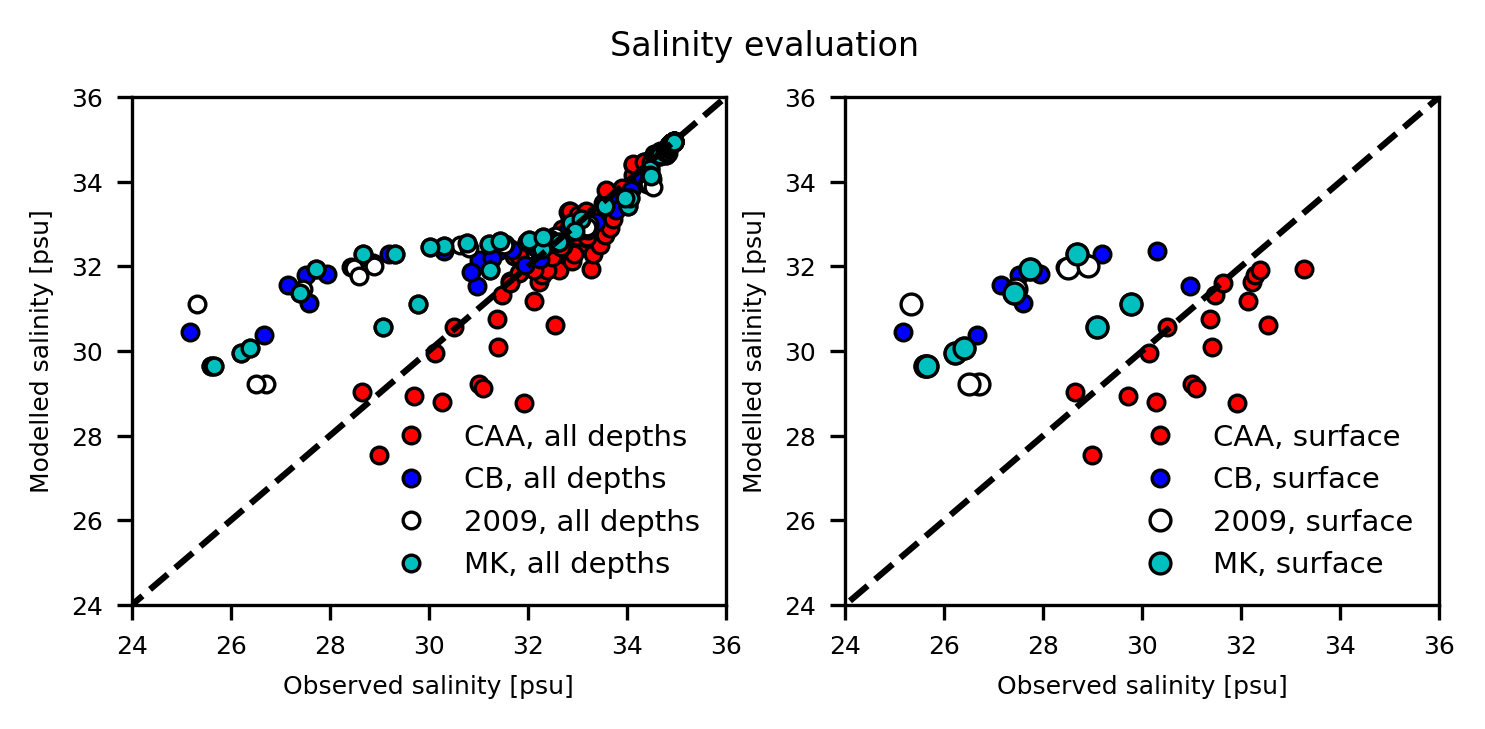

In [45]:
fig, ax = plt.subplots(1,2,figsize=(4.5*1.25,3.74*0.6), dpi=300)

ax[0].plot(S_observed_CAA, S_model_CAA, \
        '.', color='r', markersize=8, markeredgecolor='k', markeredgewidth=0.8, label='CAA, all depths')
ax[0].plot(S_observed_CB, S_model_CB, \
        '.', color='b', markersize=8, markeredgecolor='k', markeredgewidth=0.8, label='CB, all depths')
ax[0].plot(S_observed_2009, S_model_2009, \
        '.', color='w', markersize=8, markeredgecolor='k', markeredgewidth=0.8, label='2009, all depths')
ax[0].plot(S_observed_MK, S_model_MK, \
        '.', color='c', markersize=8, markeredgecolor='k', markeredgewidth=0.8, label='MK, all depths')

ax[1].plot(S_observed_CAA[(z_observed_CAA < 40) & (z_observed_CAA > 5)], S_model_CAA[(z_observed_CAA < 40) & (z_observed_CAA > 5)], \
        '.', color='r', markersize=8, markeredgecolor='k', markeredgewidth=0.8, label='CAA, surface')
ax[1].plot(S_observed_CB[(z_observed_CB < 40) & (z_observed_CB > 5)], S_model_CB[(z_observed_CB < 40) & (z_observed_CB > 5)], \
        '.', color='b', markersize=8, markeredgecolor='k', markeredgewidth=0.8, label='CB, surface')
ax[1].plot(S_observed_2009[(z_observed_2009 < 40) & (z_observed_2009 > 5)], S_model_2009[(z_observed_2009 < 40) & (z_observed_2009 > 5)], \
        '.', color='w', markersize=10, markeredgecolor='k', markeredgewidth=0.8, label='2009, surface')
ax[1].plot(S_observed_MK[(z_observed_MK < 40) & (z_observed_MK > 5)], S_model_MK[(z_observed_MK < 40) & (z_observed_MK > 5)], \
        '.', color='c', markersize=10, markeredgecolor='k', markeredgewidth=0.8, label='MK, surface')

for axis in ax.ravel():
    axis.plot([0,40],[0,40], '--k')
    axis.set_xlabel('Observed salinity [psu]', fontsize=6)
    axis.set_ylabel('Modelled salinity [psu]', fontsize=6)
    axis.tick_params(axis='both', labelsize=6)
    axis.set_xlim(24, 36)
    axis.set_ylim(24, 36)
    axis.legend(frameon=False, fontsize=7)
    
fig.suptitle('Salinity evaluation', fontsize=8)

# Salinity:Mn relationship

Text(0.5, 0.98, 'Observations')

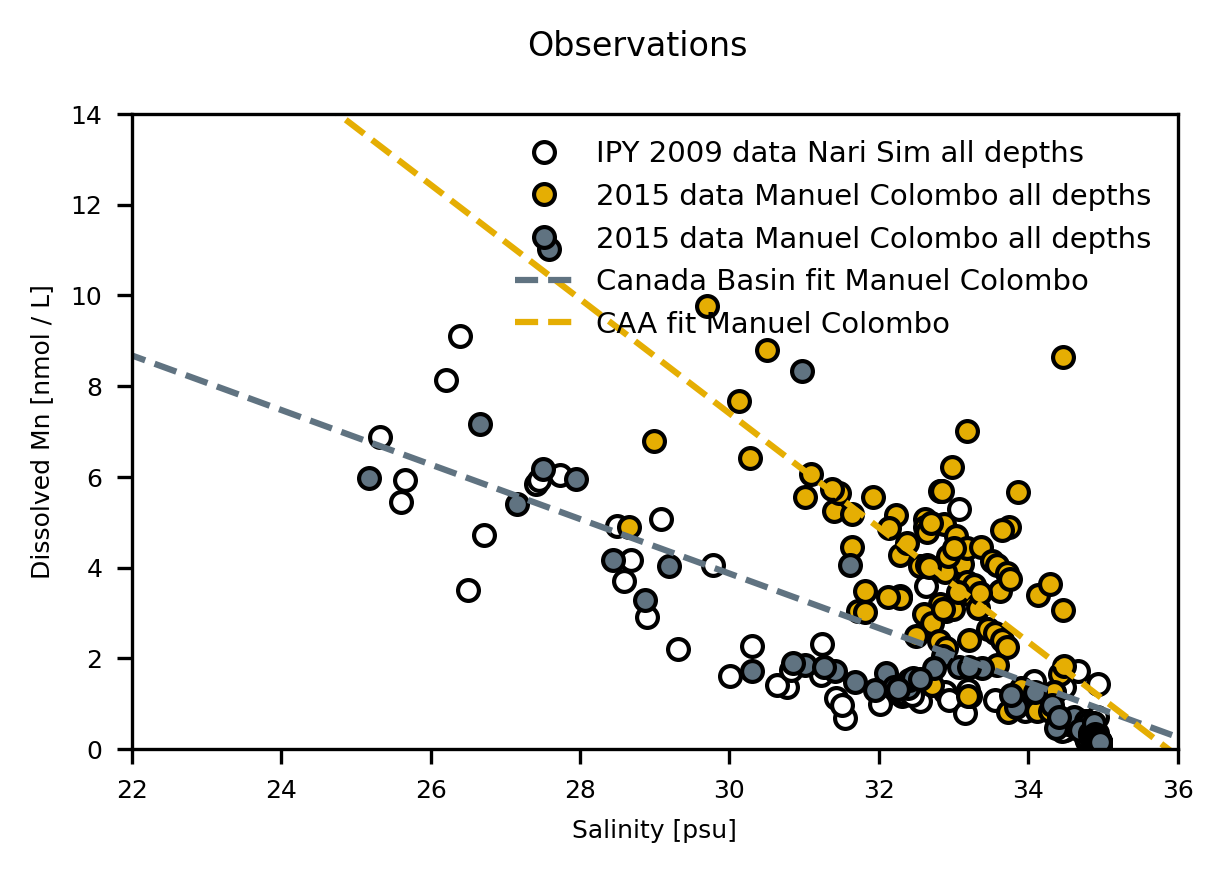

In [20]:
fig, ax = plt.subplots(1,1,figsize=(4.5,3.74*0.75), dpi=300)

# ax.plot(IPY_salinity[(IPY_depths < 40) & (IPY_depths > 5)], IPY_dMn_nmolL[(IPY_depths < 40) & (IPY_depths > 5)], \
#         '.', markersize=10, markeredgecolor='k', label='IPY 2009 data Nari Sim surface layer')
ax.plot(IPY_salinity, IPY_dMn_nmolL, \
        '.', color='w', markersize=10, markeredgecolor='k', label='IPY 2009 data Nari Sim all depths')
# ax.plot(Manuel_salinity[(Manuel_depths < 40) & (Manuel_depths > 5)], \
#         Manuel_dMn_nmolL[(Manuel_depths < 40) & (Manuel_depths > 5)], \
#         '.', color='k', markersize=10, markeredgecolor='k', label='2015 data Manuel Colombo surface layer')
ax.plot(Manuel_salinity[Manuel_station_names.str.find('CAA')!=-1], \
        Manuel_dMn_nmolL[Manuel_station_names.str.find('CAA')!=-1], '.', \
        color='#e5ae03', markersize=10, markeredgecolor='k', label='2015 data Manuel Colombo all depths')
ax.plot(Manuel_salinity[Manuel_station_names.str.find('CB')!=-1], \
        Manuel_dMn_nmolL[Manuel_station_names.str.find('CB')!=-1], '.', \
        color='#607381', markersize=10, markeredgecolor='k', label='2015 data Manuel Colombo all depths')

ax.plot(S_obs, dmn_obs_CB, '--', c='#607381', label='Canada Basin fit Manuel Colombo')
ax.plot(S_obs, dmn_obs_CAA, '--', c='#e5ae03', label='CAA fit Manuel Colombo')
ax.set_xlabel('Salinity [psu]', fontsize=6)
ax.set_ylabel('Dissolved Mn [nmol / L]', fontsize=6)
ax.tick_params(axis='both', labelsize=6)
ax.set_xlim(22,36)
ax.set_ylim(0, 14)
ax.legend(frameon=False, fontsize=7)
fig.suptitle('Observations', fontsize=8)

Seperate Canada Basin and CAA

In [20]:
# Canada Basin: ------
x_ind = np.arange(1620, 2100, 1)
y_ind = (-7/8)*x_ind + 1517 + 700

CB_indx = []
CB_indy = []

for index in range(0,len(x_ind)):
    CB_x = np.arange(x_ind[index],2180,1)
    CB_y = np.ones(CB_x.shape)*y_ind[index]
    
    CB_indx = np.append(CB_x, CB_indx)
    CB_indy = np.append(CB_y, CB_indy)
    
# Baffin Bay: ------
x_ind = np.arange(1400, 1550, 1)
y_ind = np.arange(515, 800, 1)

BB_indx = []
BB_indy = []
for xindex in x_ind:
    for yindex in y_ind:        
        BB_indx = np.append(BB_indx, xindex)
        BB_indy = np.append(BB_indy, yindex)
        
# Separate Canada Basin and the CAA: -------
mask_ini_CB   = np.zeros((isize,jsize))
mask_ini_CAA  = np.ones((isize,jsize))
mask_ini_CBBB = np.zeros((isize,jsize))

for i, j in zip(CB_indx, CB_indy):
    mask_ini_CB[int(i-imin),int(j-jmin)]   = 1
    mask_ini_CBBB[int(i-imin),int(j-jmin)] = 1
    mask_ini_CAA[int(i-imin),int(j-jmin)]  = 0
    
for i, j in zip(BB_indx, BB_indy):
    mask_ini_CBBB[int(i-imin),int(j-jmin)] = 1
    mask_ini_CAA[int(i-imin),int(j-jmin)]  = 0
    
mask_ini_CB[150:-1 ,-8:-1]   = 1
mask_ini_CBBB[150:-1 ,-8:-1] = 1
mask_ini_CAA[150:-1,-8:-1] = 0

Separate salinity and mn results based on these definitons.

In [21]:
S_CB_2015, mn_CB_2015   = mask_data(mask_ini_CBBB, sal_2015, mn_ref_2015)
S_CB_2009, mn_CB_2009   = mask_data(mask_ini_CBBB, sal_2009, mn_ref_2009)
S_CAA_2015, mn_CAA_2015 = mask_data(mask_ini_CAA, sal_2015, mn_ref_2015)

# Combine Canada Basin 2009 and 2015 model data:
S_CB_combined  = np.append(S_CB_2009, S_CB_2015)
mn_CB_combined = np.append(mn_CB_2009, mn_CB_2015)

# Combine Canada Basin 2009 and 2015 observation data:
S_CB_obs_combined  = np.append(IPY_salinity, Manuel_salinity[Manuel_station_names.str.find('CB')!=-1])
mn_CB_obs_combined = np.append(IPY_dMn_nmolL, Manuel_dMn_nmolL[Manuel_station_names.str.find('CB')!=-1])

In [22]:
# initial conditions:
S_CB_IC , mn_CB_IC  = mask_data(mask_ini_CBBB, sal_IC, dMn_IC)
S_CAA_IC, mn_CAA_IC = mask_data(mask_ini_CAA, sal_IC, dMn_IC)

In [23]:
# initial conditions:
S_CB_kox , mn_CB_kox  = mask_data(mask_ini_CBBB, sal_IC, dMn_kox)
S_CAA_kox, mn_CAA_kox = mask_data(mask_ini_CAA, sal_IC, dMn_kox)

In [24]:
def plot_mnsal(S_CAA, mn_CAA, S_CB, mn_CB, reso=200, title=''):
    
    fig, ax = plt.subplots(1,2, figsize=(4.5,3.74*0.5), dpi=300)
    st = sns.axes_style("whitegrid")

    for axis in ax.ravel():
        axis.set(xlim=(22, 36), ylim=(0, 20))
        axis.tick_params(axis='both', labelsize=6)

    with st:  
        sns.kdeplot(x=S_CAA[::reso], y=mn_CAA[::reso], levels=np.arange(0.1,1.1,0.1), \
                    fill=True, ax=ax[0], cmap="YlOrBr")
        sns.kdeplot(x=S_CB[::reso], y=mn_CB[::reso], levels=np.arange(0.1,1.1,0.1), \
                    fill=True, ax=ax[1], cmap='Blues')

        # CAA
        sns.regplot(Manuel_salinity[Manuel_station_names.str.find('CAA')!=-1], \
                    Manuel_dMn_nmolL[Manuel_station_names.str.find('CAA')!=-1], \
                    dropna=True, ci=None, \
                    scatter_kws={"s": 10, 'color':'w', 'edgecolor':'#e5ae03', 'linewidths':0.5},\
                    line_kws={"linewidth":2, 'color':'#e5ae03', 'linestyle':'--'}, truncate=False, ax=ax[0], \
                    label='2015 observations')

        # Canada Basin
        sns.regplot(Manuel_salinity[Manuel_station_names.str.find('CB')!=-1], \
                    Manuel_dMn_nmolL[Manuel_station_names.str.find('CB')!=-1], \
                    dropna=True, ci=None, \
                    scatter_kws={"s": 10, 'color':'w', 'edgecolor':'#6f818d', 'linewidths':0.5},\
                    line_kws={"linewidth":0}, truncate=False, ax=ax[1], \
                    label='2015 observations')

        # IPY data
        sns.regplot(IPY_salinity, IPY_dMn_nmolL, \
                    dropna=True, ci=None, \
                    scatter_kws={"s": 10, 'color':'w', 'edgecolor':'#39454d', 'linewidths':0.5},\
                    line_kws={"linewidth":0}, truncate=False, ax=ax[1], \
                    label='IPY 2009 observations')


        # Observations combined fit
        sns.regplot(S_CB_obs_combined, mn_CB_obs_combined, \
                    dropna=True, ci=None, \
                    scatter_kws={"s": 0}, line_kws={"linewidth":2, 'color':'#607381', 'linestyle':'--'}, truncate=False, ax=ax[1])

        # Model data
        sns.regplot(S_CAA[::reso], mn_CAA[::reso], dropna=True, ci=None, \
                    line_kws={"linewidth":3.5, 'color':'w'}, scatter_kws={"s": 0}, ax=ax[0])
        sns.regplot(S_CAA[::reso], mn_CAA[::reso], dropna=True, \
                    line_kws={"linewidth":2, 'color':'#e5ae03'}, scatter_kws={"s": 0}, ax=ax[0])
        sns.regplot(S_CB[::reso] , mn_CB[::reso], dropna=True,  \
                    ci=None, line_kws={"linewidth":3.5, 'color':'w'}, scatter_kws={"s": 0}, ax=ax[1])
        sns.regplot(S_CB[::reso] , mn_CB[::reso], dropna=True, \
                    line_kws={"linewidth":2, 'color':'#607381'}, scatter_kws={"s": 0}, ax=ax[1])

        # Legend entries:
        sns.lineplot([0,0],[0,0], lw=2, c='#e5ae03', ax=ax[0], label='Model fit')
        sns.lineplot([0,0],[0,0], lw=2, c='#e5ae03', ax=ax[0], label='Observations fit')
        ax[0].lines[4].set_linestyle("--")
        sns.lineplot([0,0],[0,0], lw=2, c='#607381', ax=ax[1], label='Model fit')
        sns.lineplot([0,0],[0,0], lw=2, c='#607381', ax=ax[1], label='Observations fit')
        ax[1].lines[6].set_linestyle("--")

        ax[0].legend(frameon=False, fontsize=5)
        ax[1].legend(frameon=False, fontsize=5)
        ax[0].set_xlabel('Salinity [psu]', fontsize=6)
        ax[1].set_xlabel('Salinity [psu]', fontsize=6)
        ax[0].set_ylabel('Dissolved Mn [nM]', fontsize=6)
        ax[1].set_ylabel('')

        ax[0].set_title('CAA', fontsize=6)
        ax[1].set_title('CB', fontsize=6)

    fig.suptitle(title, fontsize=8)
    
    return

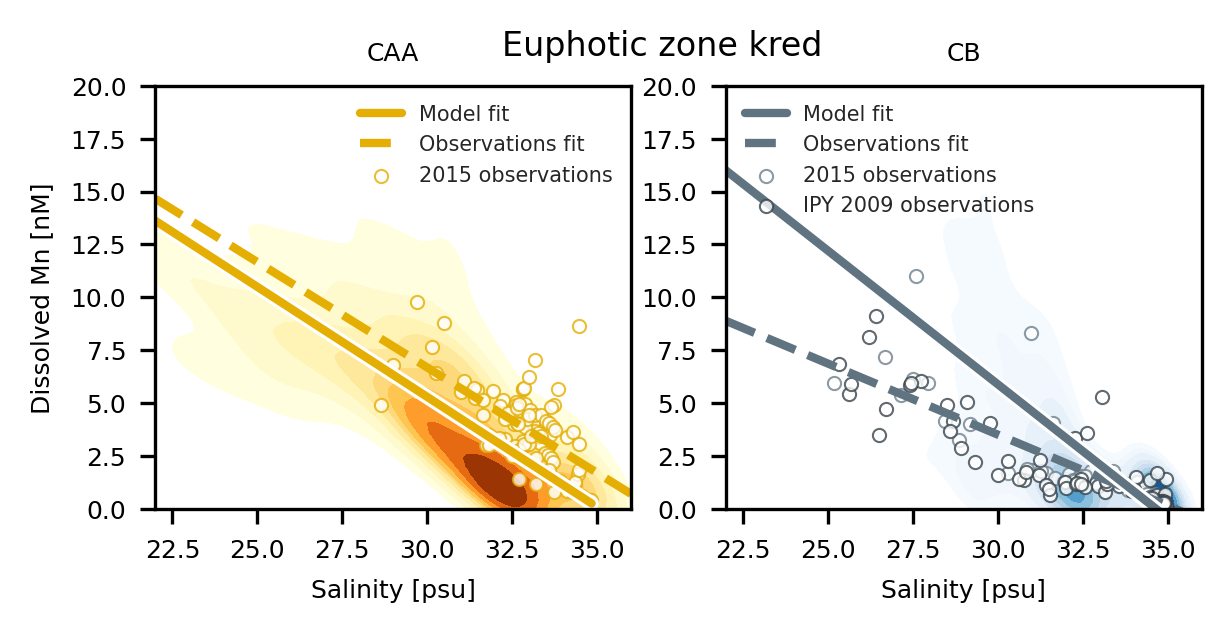

In [42]:
plot_mnsal(S_CAA_2015, mn_CAA_2015, S_CB_combined, mn_CB_combined, title='Euphotic zone kred')

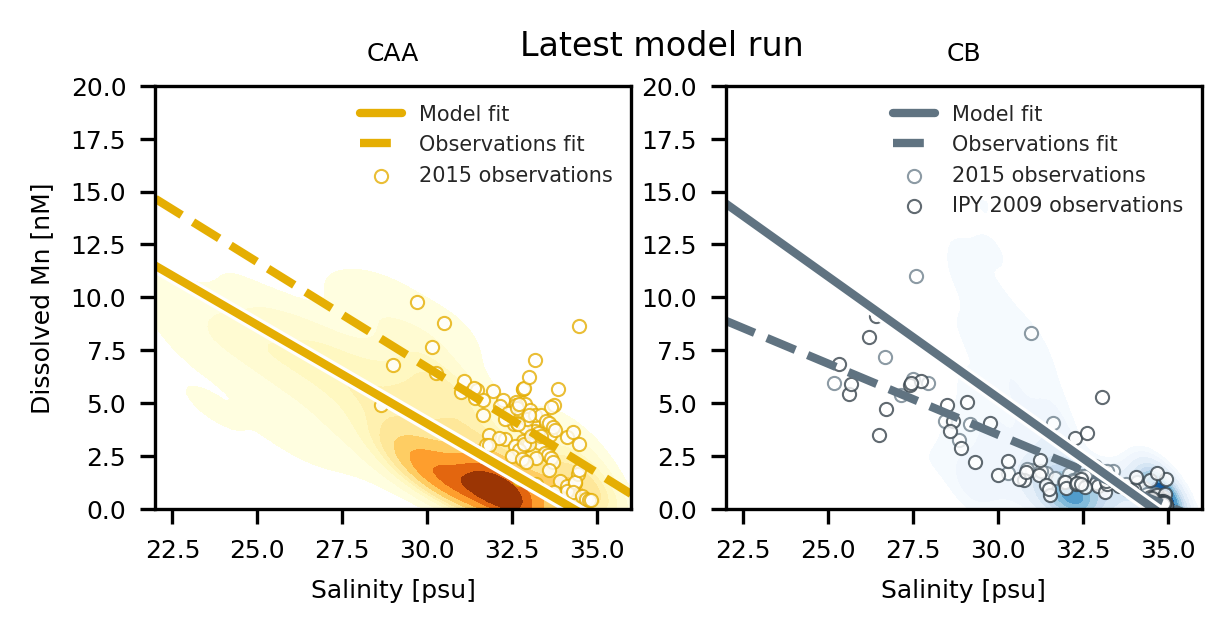

In [67]:
plot_mnsal(S_CAA_2015, mn_CAA_2015, S_CB_combined, mn_CB_combined, title='Latest model run')